#  MODIS Water Figures
Version: 0.0.0

Date modified: 07.20.2023

Modified by: Amanda Burke

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path   
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

## Data Preprocessing Functions

In [ ]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]

    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print(f'Imbalancing data, sampling {frac} from land, {1-frac} from water')
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

In [2]:
GPU = True
MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
FRAC_LAND=0.5
num_datapoints = 10000000

In [19]:
colsToDrop = [
            #'sur_refl_b01_1',
            # 'sur_refl_b02_1',
             'sur_refl_b03_1',
             'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
            # 'sur_refl_b07_1',
             # 'ndvi',
             'ndwi1','ndwi2'
            ]
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']


## Input Data

In [8]:
#############################
# VERSION 4.2.1 (targeted 500k points)
v421_TILE_IN = 'Golden'#v4.2.1
v421_DATA_VERSION='v4.2.1'
v421_offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']
#############################

v421_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{v421_DATA_VERSION}'
v421_glob_string = os.path.join(v421_data_basepath,'MOD*{}*.parquet.gzip'.format(v421_TILE_IN))
v421_data_path = sorted([fv for fv in glob.glob(v421_glob_string)])[0]
print(v421_data_path)
#Only want the one with 4.2.1 because the other file doesnt work. 

v201_colsToDropTraining = colsToDrop.copy()
v201_colsToDropTraining.extend(v201_offsets_indexes)

v421_colsToDropTraining = colsToDrop.copy()
v421_colsToDropTraining.extend(v421_offsets_indexes)

v421_X, v421_X_test, v421_y, v421_y_test = load_data(fpath=v421_data_path,
                                colsToDrop=v421_colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                trainTestSplit=True
                                )

v421_X = v421_X.iloc[:num_datapoints,:] 
v421_y = v421_y.iloc[:num_datapoints] 

print(f'data shape: {v421_X.shape}, {v421_y.shape}')

#Getting the indices that are associated with land (0) and water (1)
v421_y_water_ind = np.where(v421_y>0.5)[0]
v421_y_land_ind = np.where(v421_y<0.5)[0]

#Subset the X AND y data to later/ subset with the clusters and then combine for RFA
v421_X_water = v421_X.iloc[v421_y_water_ind,:]
v421_y_water = v421_y.iloc[v421_y_water_ind]

v421_X_land = v421_X.iloc[v421_y_land_ind,:]
v421_y_land = v421_y.iloc[v421_y_land_ind]

/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.1/MOD09_Golden_Masked_986161_4_2_1.parquet.gzip


In [9]:
##############################
#VERSION 2.0.1 (5 million points)
v201_TILE_IN = 'GLOBAL'#v2.0.1
v201_DATA_VERSION='v2.0.1'
v201_offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day']
##############################

v201_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{v201_DATA_VERSION}'
v201_glob_string = os.path.join(v201_data_basepath,'MOD*{}*.parquet.gzip'.format(v201_TILE_IN))
v201_data_path = sorted([fv for fv in glob.glob(v201_glob_string)])[0]

print(v201_data_path)

v201_X, v201_X_test, v201_y, v201_y_test = load_data(fpath=v201_data_path,
                                colsToDrop=v201_colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                trainTestSplit=True
                                )

v201_X = v201_X.iloc[:num_datapoints,:] 
v201_y = v201_y.iloc[:num_datapoints] 

print(f'data shape: {v201_X.shape}, {v201_y.shape}')

#Getting the indices that are associated with land (0) and water (1)
v201_y_water_ind = np.where(v201_y>0.5)[0]
v201_y_land_ind = np.where(v201_y<0.5)[0]

#Subset the X AND y data to later/ subset with the clusters and then combine for RFA
v201_X_water = v201_X.iloc[v201_y_water_ind,:]
v201_y_water = v201_y.iloc[v201_y_water_ind]

v201_X_land = v201_X.iloc[v201_y_land_ind,:]
v201_y_land = v201_y.iloc[v201_y_land_ind]

/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.1/MOD09_GLOBAL_5469777_2_0_1.parquet.gzip


In [ ]:
# plt.scatter(X_water.values[:,0], X_water.values[:,1],label='Water')
# plt.scatter(X_land.values[:,0], X_land.values[:,1],label='Land')
# plt.title(f'Land and Water Datapoints, {num_datapoints} Samples')
# plt.legend()
# plt.xlabel(X_water.columns[0])
# plt.ylabel(X_water.columns[1])

In [ ]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

In [ ]:
%%time
kme_water =  KMeans(n_clusters=5, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

In [ ]:
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)

In [ ]:
plt.scatter(X_water.values[:,0], X_water.values[:,1],
            c=kmeans_output_water,cmap='tab10',s=25)
plt.scatter(kme_water.cluster_centers_[:,0],kme_water.cluster_centers_[:,1],
            label='Center Point',c='k',s=50)
plt.title(f'Kmeans Clustering, Water Datapoints, {num_datapoints} Samples')
plt.legend()
plt.xlabel(X_water.columns[0])
plt.ylabel(X_water.columns[1])

In [ ]:
# plt.scatter(X_land.values[:,0], X_land.values[:,1],
#             c=kmeans_output_land,cmap='tab10',s=25)
# plt.scatter(kme_land.cluster_centers_[:,0],kme_land.cluster_centers_[:,1],
#             label='Center Point',c='k',s=50)
# plt.title(f'Kmeans Clustering, Land Datapoints, {num_datapoints} Samples')
# plt.legend()
# plt.xlabel(X_land.columns[0])
# plt.ylabel(X_land.columns[1])

### Kmeans

In [ ]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

In [ ]:
%%time
kme_water_3D =  KMeans(n_clusters=5, **common_params).fit(X_water_3D)
kmeans_output_water_3D = kme_water_3D.predict(X_water_3D)

In [ ]:
%%time
kme_land_3D =  KMeans(n_clusters=5, **common_params).fit(X_land_3D)
kmeans_output_land_3D = kme_land_3D.predict(X_land_3D)

In [ ]:
fig = plt.figure(figsize = (15, 7))

plt.suptitle(f'Kmeans Clustering, {num_datapoints} Samples')
ax1 = plt.subplot(121,projection ="3d")
# ax1 = plt.axes(projection ="3d")
ax1.set_title(f'Water Datapoints')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.tick_params(axis='both', which='minor', labelsize=10)

ax1.scatter(X_water_3D.values[:,0], X_water_3D.values[:,1], X_water_3D.values[:,2],
           marker='o',c=kmeans_output_water_3D,cmap='tab10')
ax1.scatter(kme_water_3D.cluster_centers_[:,0],kme_water_3D.cluster_centers_[:,1],kme_water_3D.cluster_centers_[:,2],
            label='Center Point',c='k',s=50)
ax1.legend()
ax1.set_xlabel(X_water_3D.columns[0])
ax1.set_ylabel(X_water_3D.columns[1])
ax1.set_zlabel(X_water_3D.columns[2])


ax2 = plt.subplot(122,projection ="3d")
# ax2 = plt.axes(projection ="3d")
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='minor', labelsize=10)

ax2.set_title(f'Land Datapoints')
ax2.scatter(X_land_3D.values[:,0], X_land_3D.values[:,1], X_land_3D.values[:,2],
           marker='o',c=kmeans_output_land_3D,cmap='tab10')
ax2.scatter(kme_land_3D.cluster_centers_[:,0],kme_land_3D.cluster_centers_[:,1],kme_land_3D.cluster_centers_[:,2],
            label='Center Point',c='k',s=50)
ax2.legend()
ax2.set_xlabel(X_land_3D.columns[0])
ax2.set_ylabel(X_land_3D.columns[1])
ax2.set_zlabel(X_land_3D.columns[2])

plt.show()

### Birch

In [ ]:
%%time
br = Birch(n_clusters=5).fit(X)
birch_output = br.predict(X)

In [ ]:
fig = plt.figure(figsize = (7, 7))
plt.title(f'Birch Clustering: {num_datapoints} Samples')
ax = plt.axes(projection ="3d")
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)

ax.scatter(X.values[:,0], X.values[:,1], X.values[:,2],marker='o',c=birch_output)

ax.set_xlabel(X.columns[0])
ax.set_ylabel(X.columns[1])
ax.set_zlabel(X.columns[2])

plt.show()

## Comparing targeted and clustered samples


In [ ]:
%%time
br = Birch(n_clusters=5).fit(X)
birch_output = br.predict(X)

In [ ]:
plt.scatter(X.values[:,0], X.values[:,1],c=birch_output)
plt.title(f'Birch Clustering: {num_datapoints} Samples')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

In [ ]:
%%time
spectral = SpectralClustering(
        n_clusters=5,
        #affinity="nearest_neighbors",
        random_state=42).fit_predict(X)

In [ ]:
plt.scatter(X.values[:,0], X.values[:,1],c=spectral)
plt.title(f'Spectral Clustering: {num_datapoints} Samples')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

## Clustering Data for Input to Random Forest

Based on the cluster analysis above on 5.03.23, 15 clusters appears to have the most data and exclude outliers so will use that number for selection 

In [ ]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
    "init":"random"
}

In [ ]:
score_water = []
for c in np.arange(1, 30):
    if c%5==0: print(c)
    kme_water = KMeans(n_clusters=c,**common_params).fit(X_water)
    score_water.append(kme_water.inertia_)

In [ ]:
score_land = []
for c in np.arange(1, 30):
    if c%5==0: print(c)
    kme_land = KMeans(n_clusters=c,**common_params).fit(X_land)
    score_land.append(kme_land.inertia_)

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(score_water,label='Water')
plt.plot(score_land,label='Land')
plt.xticks(np.arange(1,30))
plt.xlabel("Number of clusters")
plt.ylabel("kmeans inertia")
plt.title(f"Optimal number of clusters \n Data {DATA_VERSION}")
plt.legend()

### Using the best number of clusters 

In [22]:
CLUSTER_NUM=15

common_params = {
    "n_init": "auto",
    "random_state": 42,
    "init":"random"
}

In [25]:
%%time
kme_land_random =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(v201_X_land)
kmeans_output_land_random = kme_land_random.predict(v201_X_land)

CPU times: user 6min 53s, sys: 23.8 s, total: 7min 17s
Wall time: 11.6 s


In [26]:
%%time
kme_water_random = KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(v201_X_water)
kmeans_output_water_random = kme_water_random.predict(v201_X_water)

CPU times: user 3min 22s, sys: 12.4 s, total: 3min 34s
Wall time: 5.59 s


### Even Balanced Random pulled datapoints

In [27]:
COUNT_EVEN_BALANCE_LAND = np.inf
COUNT_EVEN_BALANCE_WATER = np.inf
for cluster in np.unique(kmeans_output_water_random):
    land_num = len(np.where(kmeans_output_land_random == cluster)[0])
    water_num = len(np.where(kmeans_output_water_random == cluster)[0])
    if land_num < COUNT_EVEN_BALANCE_LAND: COUNT_EVEN_BALANCE_LAND = land_num
    if water_num < COUNT_EVEN_BALANCE_WATER: COUNT_EVEN_BALANCE_WATER = water_num
    
print(COUNT_EVEN_BALANCE_LAND, COUNT_EVEN_BALANCE_WATER)
if COUNT_EVEN_BALANCE_LAND < COUNT_EVEN_BALANCE_WATER:
    COUNT = COUNT_EVEN_BALANCE_LAND
else: 
    COUNT = COUNT_EVEN_BALANCE_WATER
print(COUNT)

938 8635
938


In [29]:
# np.random.seed(42)
EB_random_ind_land = np.array([])
EB_random_ind_water = []

for cluster in np.unique(kmeans_output_water_random):
    print(f'cluster {cluster}')
    cluster_ind_water = np.where(kmeans_output_water_random == cluster)[0]
    random_pts_water = np.random.choice(cluster_ind_water,COUNT,replace=False)
    max_X_random_water = np.nanmax(v201_X_water['sur_refl_b01_1'].iloc[random_pts_water])
    if max_X_random_water < 10000:
        EB_random_ind_water = np.append(EB_random_ind_water, random_pts_water)
    else: print(f'Cluster {cluster} contains outliers')
    
    cluster_ind_land = np.where(kmeans_output_land_random == cluster)[0]
    random_pts_land = np.random.choice(cluster_ind_land,COUNT,replace=False)
    EB_random_ind_land = np.append(EB_random_ind_land, random_pts_land)
    
EB_random_ind_water = EB_random_ind_water.astype('int')
EB_random_ind_land = EB_random_ind_land.astype('int')

print(EB_random_ind_water,EB_random_ind_land)

cluster 0
cluster 1
cluster 2
cluster 3
cluster 4
cluster 5
cluster 6
cluster 7
cluster 8
cluster 9
cluster 10
cluster 11
cluster 12
cluster 13
cluster 14
Cluster 14 contains outliers
[1781608  405892  951039 ...   16424 1122190  609520] [1402907 1833649  477477 ... 1278454 1006035 1817319]


In [31]:
EB_X_cluster_land_random = v201_X_land.iloc[EB_random_ind_land]
EB_y_cluster_land_random = v201_y_land.iloc[EB_random_ind_land]
EB_X_cluster_water_random = v201_X_water.iloc[EB_random_ind_water]
EB_y_cluster_water_random = v201_y_water.iloc[EB_random_ind_water]

EB_X_cluster_random = pd.concat([EB_X_cluster_land_random,EB_X_cluster_water_random])
EB_y_cluster_random = pd.concat([EB_y_cluster_land_random,EB_y_cluster_water_random])

#Combine the data so that we can shuffle the indices and keep the data together that should be
EB_All_data_random = pd.concat([EB_X_cluster_random,EB_y_cluster_random],axis=1).sample(frac=1)

EB_X_cluster_rfa_random = EB_All_data_random[EB_X_cluster_random.columns]
EB_y_cluster_rfa_random = EB_All_data_random['water']

In [33]:
print(EB_X_cluster_land_random,EB_X_cluster_water_random)

         sur_refl_b01_1  sur_refl_b02_1  sur_refl_b07_1  ndvi
1023185             507             118             120 -6224
2136868             571             186              97 -5085
2863823              28               8             678 -5555
2652369             619             256              62 -4148
1523805             960             487             343 -3268
...                 ...             ...             ...   ...
1801475             778            2681            1276  5501
451365              582            2388             902  6080
4251262             836            3207            1403  5864
200113              636            2840            1196  6340
1935203             875            3110            1365  5608

[14070 rows x 4 columns]          sur_refl_b01_1  sur_refl_b02_1  sur_refl_b07_1   ndvi
5272990              31              36             116    746
1151443             549             767             127   1656
4242380             176             272  

### Percentage Random pulled datapoints

In [36]:
PERCENT_RANDOM_PULL = 0.15

In [37]:
# np.random.seed(42)
Per_random_ind_land = np.array([])
Per_random_ind_water = []

for cluster in np.unique(kmeans_output_water_random):
    print(f'cluster {cluster}')
    cluster_ind_water = np.where(kmeans_output_water_random == cluster)[0]
    # cluster_ind_water = np.where(bgm_water == cluster)[0]
    COUNT_RANDOM_PULL_WATER = int(PERCENT_RANDOM_PULL*len(cluster_ind_water))
    random_pts_water = np.random.choice(cluster_ind_water,COUNT_RANDOM_PULL_WATER,replace=False)
    max_X_random_water = np.nanmax(v201_X_water['sur_refl_b01_1'].iloc[random_pts_water])
    if max_X_random_water < 10000:
        Per_random_ind_water = np.append(Per_random_ind_water, random_pts_water)
    else: print(f'Cluster {cluster} contains outliers')
    
    cluster_ind_land = np.where(kmeans_output_land_random == cluster)[0]
    # cluster_ind_land = np.where(bgm_land == cluster)[0]
    COUNT_RANDOM_PULL_LAND = int(PERCENT_RANDOM_PULL*len(cluster_ind_land))
    random_pts_land = np.random.choice(cluster_ind_land,COUNT_RANDOM_PULL_LAND,replace=False)
    Per_random_ind_land = np.append(Per_random_ind_land, random_pts_land)
    print(f'{COUNT_RANDOM_PULL_WATER} Water pts {COUNT_RANDOM_PULL_LAND} Land pts')
    
Per_random_ind_water = Per_random_ind_water.astype('int')
Per_random_ind_land = Per_random_ind_land.astype('int')

print(Per_random_ind_water,Per_random_ind_land)

cluster 0
31374 Water pts 1251 Land pts
cluster 1
31209 Water pts 13008 Land pts
cluster 2
7702 Water pts 19392 Land pts
cluster 3
38506 Water pts 21910 Land pts
cluster 4
51727 Water pts 36650 Land pts
cluster 5
25177 Water pts 171 Land pts
cluster 6
6784 Water pts 34919 Land pts
cluster 7
14366 Water pts 41556 Land pts
cluster 8
5281 Water pts 42593 Land pts
cluster 9
5111 Water pts 13120 Land pts
cluster 10
26027 Water pts 140 Land pts
cluster 11
33681 Water pts 39781 Land pts
cluster 12
13339 Water pts 26957 Land pts
cluster 13
5124 Water pts 26193 Land pts
cluster 14
Cluster 14 contains outliers
1295 Water pts 42016 Land pts
[1305070 1017200  261006 ... 1173740 1388428  980442] [ 839500 2059710 1565001 ... 1723104  352432 1093255]


#### Total random dataset used for training random forest

In [39]:
Per_X_cluster_land_random = v201_X_land.iloc[Per_random_ind_land]
Per_y_cluster_land_random = v201_y_land.iloc[Per_random_ind_land]
Per_X_cluster_water_random = v201_X_water.iloc[Per_random_ind_water]
Per_y_cluster_water_random = v201_y_water.iloc[Per_random_ind_water]

Per_X_cluster_random = pd.concat([Per_X_cluster_land_random,Per_X_cluster_water_random])
Per_y_cluster_random = pd.concat([Per_y_cluster_land_random,Per_y_cluster_water_random])

#Combine the data so that we can shuffle the indices and keep the data together that should be
Per_All_data_random = pd.concat([Per_X_cluster_random,Per_y_cluster_random],axis=1).sample(frac=1)

Per_X_cluster_rfa_random = Per_All_data_random[Per_X_cluster_random.columns]
Per_y_cluster_rfa_random = Per_All_data_random['water']

In [40]:
print(Per_X_cluster_land_random,Per_X_cluster_water_random)

         sur_refl_b01_1  sur_refl_b02_1  sur_refl_b07_1  ndvi
4480999            -100             -38            1378 -4492
1040557             787             474               4 -2482
4812570             -24              -8             149 -5000
3271080             144              61             116 -4048
3572859             171              53              11 -5267
...                 ...             ...             ...   ...
4003748             620            2708            1155  6274
1121484             756            3265             839  6239
4640041             605            2503            1111  6106
636052              789            3019            1245  5856
955717              614            2358             821  5868

[359657 rows x 4 columns]          sur_refl_b01_1  sur_refl_b02_1  sur_refl_b07_1   ndvi
1029641             -10             -11              37    476
2340552              -6              -6               4      0
305584              608             588 

In [41]:
Per_All_data_random

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b07_1,ndvi,water
4416007,697,1142,745,2419,0
3835779,743,2869,1446,5885,0
5312357,21,0,11,-10000,1
3243748,489,2906,834,7119,0
4094000,28,7,61,-6000,1
...,...,...,...,...,...
3524717,80,93,57,751,1
3884780,25,15,35,-2500,1
1026997,173,-5,22,-10595,1
5116017,588,296,152,-3303,1


In [85]:
v201_X.columns

Index(['sur_refl_b01_1', 'sur_refl_b02_1', 'sur_refl_b07_1', 'ndvi'], dtype='object')

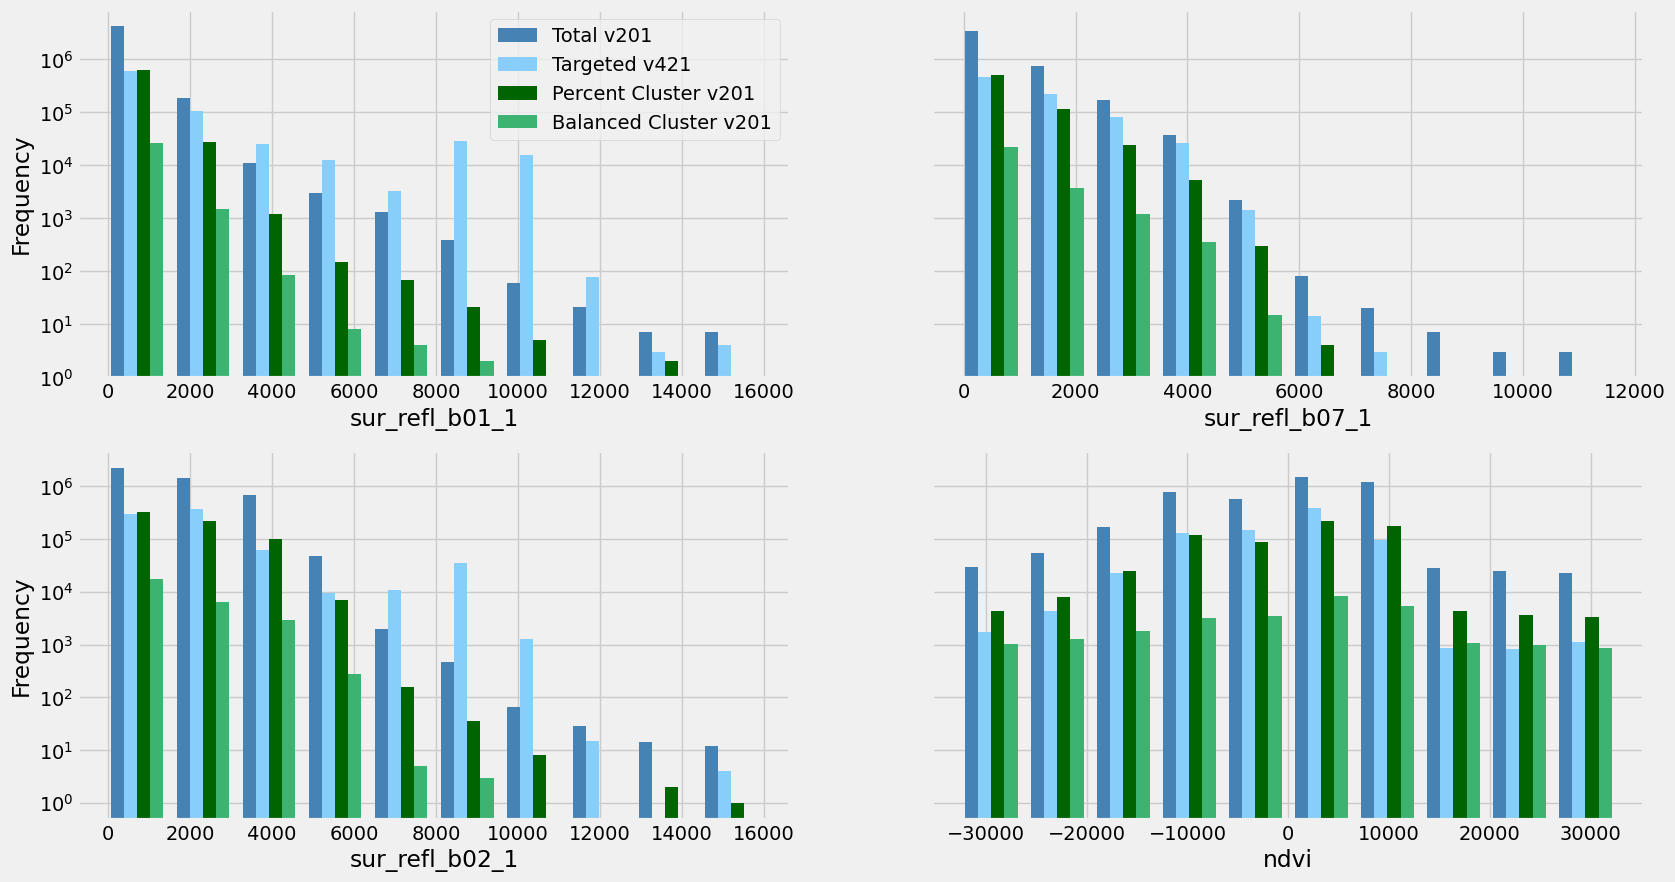

In [114]:
fig, ax = plt.subplots(2, 2, sharey='row',figsize=(18, 10))
var=0
for col in range(2):
    ax[col, 0].set_ylabel('Frequency') 
    for row in range(2):
        variable=v201_X.columns[var]
        ax[row, col].hist(
        [
        v201_X[variable].values,v421_X[variable].values,
        Per_All_data_random[variable].values, EB_All_data_random[variable].values
        ],
        label=['Total v201','Targeted v421',
               'Percent Cluster v201','Balanced Cluster v201'
        ],
        color=['steelblue','lightskyblue','darkgreen','mediumseagreen'],
        log=True) 
        ax[row, col].set_xlabel(f'{variable}')
        var+=1
     
    ax[0,0].legend(loc='upper right')
plt.show()
    

In [ ]:
print(np.unique(kmeans_output_water))

In [ ]:
np.random.seed(42)
center_ind_land = np.array([])
center_ind_water = np.array([])
water_cluster_distance = kme_water.transform(X_water)
land_cluster_distance = kme_land.transform(X_land)

# DISTANCE_BOUNDS = 


for cluster in np.unique(kmeans_output_land):
    print(f'cluster {cluster}')
    cluster_ind_water = np.where(kmeans_output_water == cluster)[0]
    print(cluster_ind_water)
    clustered_water_distance = water_cluster_distance[cluster_ind_water,cluster]
    
    centroid_cluster_pts_water = np.where(clustered_water_distance < 
                    np.nanpercentile(clustered_water_distance,10))[0]
    center_ind_water = np.append(center_ind_water, centroid_cluster_pts_water)
    
#     fig = plt.figure(figsize = (25, 10))
#     ax = plt.subplot(111,projection='3d')
#     # No random sample
#     # ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}',
#     #        c=clustered_points_land) 
#     ax.scatter(X_land.values[cluster_ind_water,0], 
#                X_land.values[cluster_ind_water,1],
#                X_land.values[cluster_ind_water,2],
#                label=f'All Land {len(y_land)}',
#                alpha=0.2
#            ) 
#     ax.scatter(X_land.values[centroid_cluster_pts_water,0], 
#                X_land.values[centroid_cluster_pts_water,1],
#                X_land.values[centroid_cluster_pts_water,2],
#                label=f'Cluster',
#            ) 
#     plt.show()
    
    cluster_ind_land = np.where(kmeans_output_land == cluster)[0]
    clustered_land_distance = land_cluster_distance[cluster_ind_land,cluster]
    centroid_cluster_pts_land = np.where(clustered_land_distance < np.nanpercentile(clustered_land_distance,10))[0]
    center_ind_land = np.append(center_ind_land, centroid_cluster_pts_land)
    
        
    print(f'Pulling {len(centroid_cluster_pts_water)} Water pts and {len(centroid_cluster_pts_land)} Land pts')
    
    #https://stackoverflow.com/questions/54240144/distance-between-nodes-and-the-centroid-in-a-kmeans-cluster 
    #how to identify distance from the center 
    
center_ind_water = center_ind_water.astype('int')
center_ind_land = center_ind_land.astype('int')

print(np.shape(center_ind_land),np.shape(center_ind_water))
print(center_ind_water,center_ind_land)

In [ ]:
X_cluster_land_center = X_land.iloc[center_ind_land]
y_cluster_land_center = y_land.iloc[center_ind_land]
X_cluster_water_center = X_water.iloc[center_ind_water]
y_cluster_water_center = y_water.iloc[center_ind_water]

X_cluster_center = pd.concat([X_cluster_land_center,X_cluster_water_center])
y_cluster_center = pd.concat([y_cluster_land_center,y_cluster_water_center])

#Combine the data so that we can shuffle the indices and keep the data together that should be
All_data_center = pd.concat([X_cluster_center,y_cluster_center],axis=1).sample(frac=1)

X_cluster_rfa_center = All_data_center[X_cluster_center.columns]
y_cluster_rfa_center = All_data_center['water']

In [ ]:
# clustered_points_land = np.ones(np.shape(X_land.iloc[:,0]))
# clustered_points_land[center_ind_land] = 2.0
# print(clustered_points_land[:1200])

# fig = plt.figure(figsize = (25, 10))
# ax = plt.subplot(111)
# #No random sample
# ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}',
#            c=clustered_points_land)
# # #Randomly sampled data
# # ax.scatter(X_random_water.values[:,0], X_random_water.values[:,1],label=f'Samp Water {len(y_random_water)}')
# # ax.scatter(X_random_land.values[:,0], X_random_land.values[:,1],label=f'Samp Land {len(y_random_land)}')

# # ax.set_title(f'{DATA_VERSION} Land and Water Datapoints'+ 
# #     f'\n {int(100*PERCENT_RANDOM_PULL)}% Randomly Chosen from {len(np.unique(kmeans_output_land))} Clusters')
# # ax.tick_params(axis='both', which='major', labelsize=10)
# # ax.tick_params(axis='both', which='minor', labelsize=10)
# # ax.legend(loc='lower right',fontsize="12")
# # ax.set_xlabel(X_random_water.columns[0])
# # ax.set_ylabel(X_random_water.columns[1])

# plt.show()

In [ ]:
# #No random sample
# ax.hist(X_water.values[:,0],label=f'All Water {len(y_water)}',alpha=0.8)
# ax.hist(X_land.values[:,0],label=f'All Land {len(y_land)}', alpha=0.8)
# ax.hist(X_random_water.values[:,0],label=f'Samp Water {len(y_random_water)}', alpha=0.8)
# ax.hist(X_random_land.values[:,0], label=f'Samp Land {len(y_random_land)}',alpha=0.8) 
# # ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}')
# # #Randomly sampled data
# # ax.scatter(X_random_water.values[:,0], X_random_water.values[:,1],label=f'Samp Water {len(y_random_water)}')
# # ax.scatter(X_random_land.values[:,0], X_random_land.values[:,1],label=f'Samp Land {len(y_random_land)}')

# ax.set_title(f'{DATA_VERSION} Land and Water Datapoints'+ 
#     f'\n {int(100*PERCENT_RANDOM_PULL)}% Randomly Chosen from {len(np.unique(kmeans_output_land))} Clusters')
# ax.tick_params(axis='both', which='major', labelsize=10)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.legend(loc='lower right',fontsize="12")
# ax.set_xlabel(X_random_water.columns[0])
# # ax.set_ylabel(X_random_water.columns[1])

# plt.show()

In [ ]:
y_cluster_water_random 
y_cluster_water_center

In [ ]:
fig = plt.figure(figsize = (15, 7))

plt.suptitle(f'{DATA_VERSION} Land and Water Datapoints,'+ 
    f' {int(100*PERCENT_RANDOM_PULL)}% Randomly Chosen from {len(np.unique(kmeans_output_land))} Clusters')

ax = plt.subplot(121)
#No random sample
# ax.scatter(X_water.values[:,0], X_water.values[:,1],label=f'All Water {len(y_water)}')
# ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}')
#Randomly sampled data
ax.set_title('Water Datapoints')
ax.scatter(X_cluster_water_random.values[:,0], X_cluster_water_random.values[:,1],label=f'Cluster Water Random {len(y_cluster_water_random )}')
ax.scatter(X_cluster_water_center.values[:,0], X_cluster_water_center.values[:,1],label=f'Cluster Water Centered {len(y_cluster_water_center)}')
ax.legend(loc='lower right',fontsize="12")
           
    
ax = plt.subplot(122)
#No random sample
# ax.scatter(X_water.values[:,0], X_water.values[:,1],label=f'All Water {len(y_water)}')
# ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}')
#Randomly sampled data
ax.set_title('Land Datapoints')
ax.scatter(X_cluster_land_random.values[:,0], X_cluster_land_random.values[:,1],label=f'Cluster Land Random {len(y_cluster_land_random )}')
ax.scatter(X_cluster_land_center.values[:,0], X_cluster_land_center.values[:,1],label=f'Cluster Land Centered {len(y_cluster_land_center)}')
ax.legend(loc='lower right',fontsize="12")
           
plt.show()

https://medium.com/@prasadostwal/multi-dimension-plots-in-python-from-2d-to-6d-9a2bf7b8cc74 for adding in more dimensions for plotting

#### paths

In [19]:
import optuna
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc, matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.inspection import permutation_importance


#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal
from pprint import pprint

In [20]:
FIGURE_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

qaMaskPath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
waterMaskPath = '/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

test_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/'


TILE = 'h11v02'
DAY = 233
YEAR = 2006

# TILE = 'h21v10'
# DAY = 100
# YEAR = 2019

FRAC_LAND = 0.5

##Add in the other stuff for tuning
frac_water = int(100*(1.0-FRAC_LAND))
if len(colsToDrop) >= 1:
    save_file = f"{TILE}_{DAY}_{YEAR}_frac-water{frac_water}_no-vars_{'-'.join(colsToDrop)}"
else: 
     save_file = f"{TILE}_{DAY}_{YEAR}_frac-water{frac_water}_all-vars"

print(save_file)

h11v02_233_2006_frac-water50_no-vars_sur_refl_b03_1-sur_refl_b04_1-sur_refl_b05_1-sur_refl_b06_1-ndwi1-ndwi2


#### RF FUNCTIONS

In [21]:
def rf_objective(trial):
    list_trees = [75, 100, 125, 150, 175, 200, 250, 300, 400, 500]
    max_depth = [5, 10, 30, 50, 80, 90, 100, 110]
    min_samples_leaf = [1, 2, 3, 4, 5]
    min_samples_split = [2, 4, 8, 10]
    bootstrap = [True, False]
    max_features = ['auto', 'sqrt', 'log2']
    
    # if TREES_AND_DEPTH_ONLY:
    #     param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
    #                'criterion':'gini', 
    #                'max_depth':trial.suggest_categorical('max_depth', max_depth), 
    #                'min_samples_split':2, 
    #                'min_samples_leaf':1, 
    #                'min_weight_fraction_leaf':0.0, 
    #                'max_features':'auto', 
    #                'max_leaf_nodes':None, 
    #                'min_impurity_decrease':0.0, 
    #                'bootstrap':True, 
    #                'oob_score':False, 
    #                'n_jobs':-1, 
    #                # 'random_state':42, 
    #                'verbose':0, 
    #                'warm_start':True, 
    #                'class_weight':None, 
    #                'ccp_alpha':0.0, 
    #                'max_samples':None
    #                   }
    # else:
    param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
                       'max_depth':trial.suggest_categorical('max_depth', max_depth), 
                       'min_samples_split':trial.suggest_categorical('min_samples_split', min_samples_split), 
                       'min_samples_leaf':trial.suggest_categorical('min_samples_leaf', min_samples_leaf), 
                       'bootstrap': trial.suggest_categorical('bootstrap', bootstrap),
                       'criterion':'gini', 
                       #'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 1e-8, 1.0, log=True), 
                       'max_features':trial.suggest_categorical('max_features', max_features), 
                       'max_leaf_nodes':None, 
                       'min_impurity_decrease':0.0, 
                       'oob_score':False, 
                       'n_jobs':-1, 
                       # 'random_state':42, 
                       'verbose':0, 
                       'warm_start':False, 
                       'class_weight':None, 
                       'ccp_alpha':0.0, 
                       'max_samples':None
                      }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    #######################
    # HERE IS WHERE TO CHANGE THE X,Y DATASET USED FOR TRAINING
    #######################
   
    cv_scores = np.empty(5)
    # for idx, (train_idx, val_idx) in enumerate(cv.split(X,y)):
    #     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    #     y_train, y_val = y.iloc[train_idx],  y.iloc[val_idx]

    for idx, (train_idx, val_idx) in enumerate(cv.split(X_cluster_rfa_random,  y_cluster_rfa_random)):    
        X_train, X_val = X_cluster_rfa_random.iloc[train_idx], X_cluster_rfa_random.iloc[val_idx]
        y_train, y_val = y_cluster_rfa_random.iloc[train_idx],  y_cluster_rfa_random.iloc[val_idx]
        
    # for idx, (train_idx, val_idx) in enumerate(cv.split(X_cluster_rfa_center, y_cluster_rfa_center)):
    #     X_train, X_val = X_cluster_rfa_center.iloc[train_idx], X_cluster_rfa_center.iloc[val_idx]
    #     y_train, y_val = y_cluster_rfa_center.iloc[train_idx], y_cluster_rfa_center.iloc[val_idx]

        model = skRF(**param)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        cv_scores[idx] = f1_score(y_val, preds)
        if cv_scores[idx] == 0.0:
            print('Pruning because of 0.0 score.')
            return 0.0
        print('Fold {}: {}'.format(idx, cv_scores[idx]))
    return np.mean(cv_scores)

search_space={
    "n_estimators": [75, 100, 125, 150, 175, 200, 250, 300, 400, 500],
    "max_depth" : [5,10, 30, 50, 80, 90, 100, 110],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "min_samples_split" : [2, 4, 8, 10],
    "bootstrap" : [True, False],
    "max_features" : ['auto', 'sqrt', 'log2'],
    
}

In [22]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'): os.remove('tmp.vrt')
    
    return img

In [23]:
def predictRaster(img_chunk, classifier, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [24]:
import folium
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 


# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} exists.'.format(filename))

#### Training RF

In [25]:
TREES_AND_DEPTH_ONLY = False
GRID_SEARCH = True

In [ ]:
%%time

optuna.logging.set_verbosity(optuna.logging.INFO)
if GRID_SEARCH:
    study = optuna.create_study(study_name='RF Tuning Grid Search', 
                                direction='maximize',
                                sampler=optuna.samplers.GridSampler(search_space))
    
else:
    study = optuna.create_study(study_name='RF Tuning',
                                direction='maximize')
#Objective is under the functions area

#####################################################################
#CHANGE HERE FOR DIFFERENT MODELING TYPE
#rf_objective or xgb_objective
#####################################################################

study.optimize(rf_objective, n_trials=25, timeout=30*600)

[I 2023-06-27 17:33:36,208] A new study created in memory with name: RF Tuning Grid Search


Fold 0: 0.9770390243489594
Fold 1: 0.9771351259935734
Fold 2: 0.9780720670438305
Fold 3: 0.9770723700908645


[I 2023-06-27 17:34:00,746] Trial 0 finished with value: 0.9773991900110156 and parameters: {'n_estimators': 100, 'max_depth': 80, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 0 with value: 0.9773991900110156.


Fold 4: 0.97767736257785
Fold 0: 0.9762632117863097
Fold 1: 0.9764205578241645
Fold 2: 0.9775022413180642
Fold 3: 0.9764825310887404


[I 2023-06-27 17:35:28,343] Trial 1 finished with value: 0.9767255226544774 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 0 with value: 0.9773991900110156.


Fold 4: 0.9769590712551086
Fold 0: 0.9772299872935197
Fold 1: 0.9773648448539927
Fold 2: 0.9781223287659639
Fold 3: 0.9774413169393354


[I 2023-06-27 17:35:47,552] Trial 2 finished with value: 0.9776163816971281 and parameters: {'n_estimators': 125, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 2 with value: 0.9776163816971281.


Fold 4: 0.9779234306328277
Fold 0: 0.976717812439171
Fold 1: 0.9766820541436277
Fold 2: 0.9776868032412498
Fold 3: 0.976905116404981


[I 2023-06-27 17:36:12,288] Trial 3 finished with value: 0.977004663841835 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9776163816971281.


Fold 4: 0.977031532980146
Fold 0: 0.9769394162498837
Fold 1: 0.977138219080794
Fold 2: 0.9779796032269521
Fold 3: 0.977035808569688


[I 2023-06-27 17:37:57,056] Trial 4 finished with value: 0.9773401638489018 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 2 with value: 0.9776163816971281.


Fold 4: 0.9776077721171911
Fold 0: 0.9756395363626342
Fold 1: 0.9758481934855352
Fold 2: 0.9763998305802626
Fold 3: 0.9759557932384674


[I 2023-06-27 17:38:38,995] Trial 5 finished with value: 0.9760377723713898 and parameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 2 with value: 0.9776163816971281.


Fold 4: 0.9763455081900498
Fold 0: 0.9757342900519919
Fold 1: 0.9757837050338384
Fold 2: 0.9764411876826634
Fold 3: 0.9759674479718561


[I 2023-06-27 17:38:55,139] Trial 6 finished with value: 0.9760517588490177 and parameters: {'n_estimators': 175, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 2 with value: 0.9776163816971281.


Fold 4: 0.9763321635047386
Fold 0: 0.9759337925431989
Fold 1: 0.9762126155978968
Fold 2: 0.9772225558440679
Fold 3: 0.9761661012073474


[I 2023-06-27 17:40:49,922] Trial 7 finished with value: 0.9764588409190745 and parameters: {'n_estimators': 400, 'max_depth': 90, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 2 with value: 0.9776163816971281.


Fold 4: 0.9767591394028613
Fold 0: 0.9761856402965369
Fold 1: 0.9764700908898754
Fold 2: 0.9775202976995941
Fold 3: 0.9764974619289339


[I 2023-06-27 17:43:12,579] Trial 8 finished with value: 0.9767414712264368 and parameters: {'n_estimators': 500, 'max_depth': 90, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9776163816971281.


Fold 4: 0.977033865317244
Fold 0: 0.9757458572906597
Fold 1: 0.9756659662441537
Fold 2: 0.9763928873835732
Fold 3: 0.9759732772653282


[I 2023-06-27 17:43:22,617] Trial 9 finished with value: 0.9760147187859441 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 2 with value: 0.9776163816971281.


Fold 4: 0.976295605746006
Fold 0: 0.9761435281174629
Fold 1: 0.9764111062261153
Fold 2: 0.9774326701854108
Fold 3: 0.9764239127676312


[I 2023-06-27 17:44:16,214] Trial 10 finished with value: 0.9766775202757867 and parameters: {'n_estimators': 175, 'max_depth': 110, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 2 with value: 0.9776163816971281.


Fold 4: 0.9769763840823129
Fold 0: 0.9742886411161625
Fold 1: 0.974101242903436
Fold 2: 0.975274167343623
Fold 3: 0.9745425010787075


[I 2023-06-27 17:44:40,059] Trial 11 finished with value: 0.9746347898170107 and parameters: {'n_estimators': 75, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 2 with value: 0.9776163816971281.


Fold 4: 0.9749673966431245
Fold 0: 0.9768158126311515
Fold 1: 0.9769868109570511
Fold 2: 0.9779608267649944
Fold 3: 0.9769023808315143


[I 2023-06-27 17:45:35,617] Trial 12 finished with value: 0.9772043278941315 and parameters: {'n_estimators': 250, 'max_depth': 90, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 2 with value: 0.9776163816971281.


Fold 4: 0.9773558082859464
Fold 0: 0.9762458851306179
Fold 1: 0.9762023518670375
Fold 2: 0.9772410118488823
Fold 3: 0.9764577499936554


[I 2023-06-27 17:46:31,181] Trial 13 finished with value: 0.9766105129383824 and parameters: {'n_estimators': 250, 'max_depth': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 2 with value: 0.9776163816971281.


Fold 4: 0.9769055658517183
Fold 0: 0.9769756048028837
Fold 1: 0.9770890399377768
Fold 2: 0.9779788583509513
Fold 3: 0.9769948642451625


[I 2023-06-27 17:47:55,762] Trial 14 finished with value: 0.9772940284493732 and parameters: {'n_estimators': 400, 'max_depth': 80, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 2 with value: 0.9776163816971281.


Fold 4: 0.977431774910091
Fold 0: 0.9771539419403479
Fold 1: 0.977451370262884
Fold 2: 0.9781907736055043
Fold 3: 0.9775907042921508


[I 2023-06-27 17:48:48,382] Trial 15 finished with value: 0.9776877832602322 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.9776877832602322.


Fold 4: 0.9780521262002744
Fold 0: 0.9761759729272419
Fold 1: 0.9763171022482264
Fold 2: 0.9773661507231667
Fold 3: 0.9763991337889965


[I 2023-06-27 17:50:15,986] Trial 16 finished with value: 0.9766299476332811 and parameters: {'n_estimators': 300, 'max_depth': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.9776877832602322.


Fold 4: 0.976891378478774
Fold 0: 0.9768532231992485
Fold 1: 0.9770623198085849
Fold 2: 0.978031456113648
Fold 3: 0.9770625512940917


[I 2023-06-27 17:50:55,804] Trial 17 finished with value: 0.9772862287534597 and parameters: {'n_estimators': 175, 'max_depth': 80, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 15 with value: 0.9776877832602322.


Fold 4: 0.9774215933517255
Fold 0: 0.9759944491923406


In [99]:
print("Number of finished trials: {}".format(len(study.trials)))
trials = study.best_trials
trial_score = max([trial.values[0]
                   for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[0] == trial_score][0]
print(best_trial_params)
print(trial_score)


Number of finished trials: 25
{'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}
0.9777463893238705


In [100]:
print(len(X_cluster_land_random),len(X_cluster_water_random))

359814 295240


In [101]:
# 359814 295240
# Number of finished trials: 25
# {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}
# 0.9777463893238705

# 359815 264361
# Number of finished trials: 25
# {'n_estimators': 75, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}
# 0.9866126705045699

# 359814 295242
# Number of finished trials: 25
# {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'log2'}
# 0.977886421736911

# 359815 295240
# Number of finished trials: 25
# {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'auto'}
# 0.977879959920102

# 359813 295242
# Number of finished trials: 25
# {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'sqrt'}
# 0.9777882842687797

# 359832 295240
# Number of finished trials: 25
# {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'log2'}
# 0.9780277540040061

# 359830 295237
# Number of finished trials: 25
# {'n_estimators': 300, 'max_depth': 100, 'min_samples_split': 4, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'sqrt'}
# 0.9781299044897317

# 359832 295239
# Number of finished trials: 25
# {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'sqrt'}
# 0.9780948126559051


# 359831 295239
# Number of finished trials: 25
# {'n_estimators': 125, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'sqrt'}
# 0.9779760360768524


# 13770 12852
# Number of finished trials: 25
# {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'sqrt'}
# 0.9117162188038987

# 13770 12852
# Number of finished trials: 25
# {'n_estimators': 250, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'log2'}
# 0.9104124369067913

# 13800 13800
# Number of finished trials: 25
# {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'auto'}
# 0.9152865904511502

# 13770 12852
# Number of finished trials: 25
# {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'log2'}
# 0.9135491629622192

# 13800 12880
# Number of finished trials: 25
# {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}
# 0.9112970459116907

# 13815 12894
# Number of finished trials: 25
# {'n_estimators': 75, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'auto'}
# 0.9109082672418902


# 13800 12880
# Number of finished trials: 25
# {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'auto'}
# 0.914162230125638

# 13635 12726
# Number of finished trials: 25
# {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'sqrt'}
# 0.933084757242249

# 13485 12586
# Number of finished trials: 25
# {'n_estimators': 75, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}
# 0.9324441954116314

# 14355 13398
# Number of finished trials: 25
# {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}
# 0.9344986953730517

SyntaxError: invalid syntax (1306318926.py, line 1)

In [ ]:
hyperparameters = best_trial_params
hyperparameters['n_jobs'] = -1
print('Using these params:')
print(hyperparameters)

tuned_classifier = skRF(**hyperparameters)


In [ ]:
%%time 
tuned_classifier.fit(X_cluster_rfa_random , y_cluster_rfa_random)

Saving output cluster model

In [ ]:
import pickle
# save the model to disk
filename = 'MODIS_RFA_v201_NoCluster_sfcref127_ndvi.pkl'
pickle.dump(tuned_classifier, open(filename, 'wb'))

In [ ]:
tabularGen = TabularModisDataGenerator(tile=TILE, year=YEAR, julianDays=[DAY])
sensorDir = f'/css/modis/Collection6.1/L2G/MOD09GA/{YEAR}'
modisFilesDict = tabularGen._readFiles(julianDay=DAY, sensorDir=sensorDir)
modisFilesList = list(modisFilesDict.values())
qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)


#######
#in the TabularModisDataGenerator on line ~270 I commented out the line that would write out the qa mask
#qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)

In [ ]:
vars_list_gq = [fn for fn in modisFilesList if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in modisFilesList if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list


#IMPORTANT FOR QGIS POTENTIALLY BECAUSE OF LIST OF MODIS DATA

#### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [ ]:
%%time

im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

In [ ]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im, tuned_classifier, colsToDrop=colsToDrop)

In [ ]:
water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
print(water_list)
print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
water_mask_path = water_list[0]
print(water_mask_path)
water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMask = None

#### Mask out results if QA Mask says pixel is "bad"

In [ ]:
maskedResult = np.where(qa_mask == 0, predictedWaterMask, 255)
waterMasked = np.where(qa_mask == 0, waterMaskMatrix, 255)
# # waterMaskRavel = waterMasked.ravel()
# imWater = (waterMaskRavel == 1)

In [ ]:
# plt.matshow(predictedWaterMask)
# plt.matshow(maskedResult-waterMasked)
# plt.matshow(waterMasked-maskedResult)
# plt.matshow(waterMaskMatrix)

# plt.matshow(waterMasked)
# plt.matshow(maskedResult)

In [ ]:
#outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}_25trials_65water_noextradata_v42_allvars.tif'.format(YEAR, DAY, TILE, MODEL))
# outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}_25trials_75water_noextradata_v42_allvars.tif'.format(YEAR, DAY, TILE, MODEL))
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}_xgb.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))


print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

In [ ]:
mask_3857 = reproject_to_3857(outPath)
mod44_3857 = reproject_to_3857(water_mask_path)
qa_3857 = reproject_to_3857(qa_mask_path)

mask_d = get_bounds(mask_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)

cleanup(mask_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

In [ ]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)


# folium.Marker(location=[-16.4835, -72.9978]).add_to(m)

In [ ]:
from folium import plugins

In [ ]:

m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(plugins.MeasureControl())
m.add_child(folium.LayerControl())

m